In [55]:
import keras
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [56]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()

In [57]:
x_train = np.concatenate((x_train, x_test), axis=0)
labels_train = np.concatenate((labels_train, labels_test), axis=0)

In [58]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape

(70000, 28, 28)

# Reshape the data to fit the model

In [59]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# One-hot encoding

In [60]:
from keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

# Data augmentation

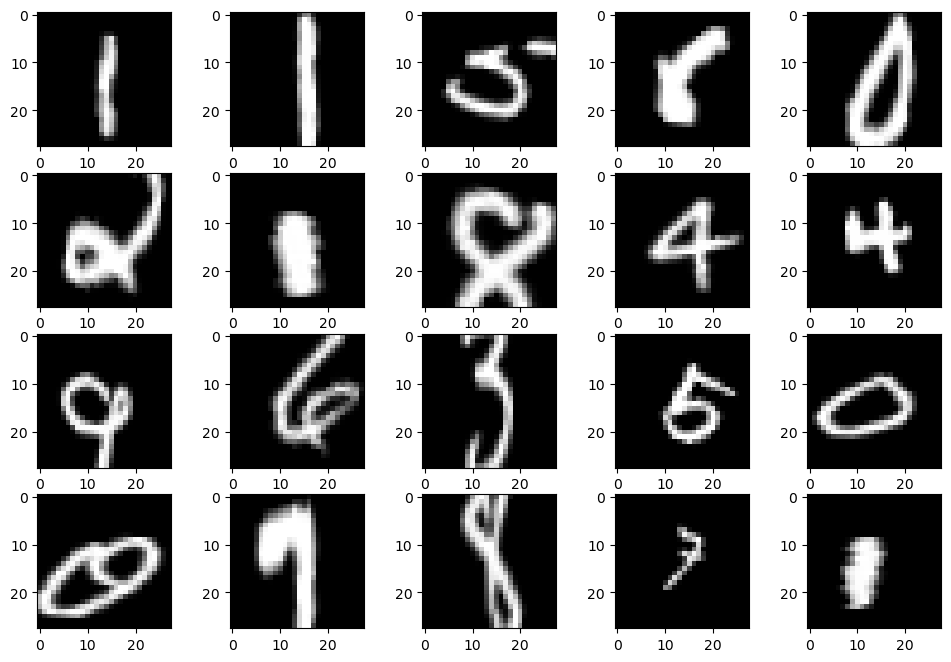

In [61]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.5,
    shear_range=0.2,
    fill_mode='nearest')

#Plots our figures
pic = datagen.flow(x_train, batch_size=1024)
plt.figure(figsize=(12,8))
for i in range(1,21):
  plt.subplot(4, 5, i)
  batch = pic.next()
  image_ = batch[0].astype('float32')
  plt.imshow(image_, cmap='gray')
plt.show()

# Define the CNN model

In [62]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_27 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 12, 12, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 10, 10, 128)      

# K-fold cross-validation

In [63]:
# Train and evaluate the model with k-fold cross-validation
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

historys = []

batch_size = 2048
epochs = 10
n_splits = 10

kfold = KFold(n_splits=n_splits, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print('Fold:', fold+1)
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    x_val_fold = x_train[val_indices]
    y_val_fold = y_train[val_indices]
    
    # Fit the model with data augmentation
    history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[EarlyStopping(patience=5)])
    
    historys.append(history)

Fold: 1
Epoch 1/10


2023-02-21 18:48:20.842571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 1.3875 - accuracy: 0.5693

2023-02-21 18:48:31.880698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 14s 398ms/step - loss: 1.3875 - accuracy: 0.5693 - val_loss: 2.2338 - val_accuracy: 0.4416
Epoch 2/10
31/31 [==============================] - 12s 390ms/step - loss: 0.5004 - accuracy: 0.8449 - val_loss: 2.2170 - val_accuracy: 0.2544
Epoch 3/10
31/31 [==============================] - 12s 373ms/step - loss: 0.3245 - accuracy: 0.9022 - val_loss: 2.2697 - val_accuracy: 0.2031
Epoch 4/10
31/31 [==============================] - 12s 371ms/step - loss: 0.2574 - accuracy: 0.9230 - val_loss: 2.4646 - val_accuracy: 0.1410
Epoch 5/10
31/31 [==============================] - 12s 372ms/step - loss: 0.2200 - accuracy: 0.9332 - val_loss: 2.4051 - val_accuracy: 0.1773
Epoch 6/10
31/31 [==============================] - 12s 373ms/step - loss: 0.1884 - accuracy: 0.9436 - val_loss: 2.6331 - val_accuracy: 0.1299
Epoch 7/10
31/31 [==============================] - 12s 374ms/step - loss: 0.1771 - accuracy: 0.9476 - val_loss: 2.5873 - val_accuracy: 0.2669
Fold: 2
Ep

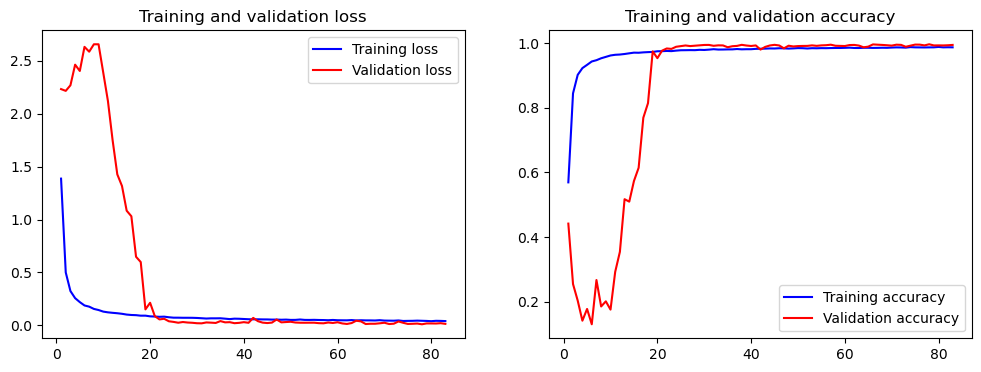

In [64]:
losses = [loss for history in historys for loss in history.history['loss']]
val_losses = [val_loss for history in historys for val_loss in history.history['val_loss']]
accuracies = [accuracy for history in historys for accuracy in history.history['accuracy']]
val_accuracies = [val_accuracy for history in historys for val_accuracy in history.history['val_accuracy']]

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
    

In [65]:
model.save("network_for_mnist.h5")